# Send Time Recommendation
## Leandro Corrêa Gonçalves

## Summary

1. Defining the problem
2. Dataset - Loading and processing
3. Exploratory Data Analysis
4. Solution Design
5. Solution Implementation
6. Solution Evaluation
7. Sensitivity Analysis
8. Conclusion and improvements

## 1. Defining the problem

### What is the best time to send emails to my customers in order to increase email open rate?
Email is one of the most used communication channels in digital Marketing Campaigns, and CRM systems usually provide many features helping companies to reach their customers in a <mark> personalized way</mark>. 

> Email Open Rate is calculated as the number of opened emails divided by the number of received 

### <b> Enhancing email open rate means to increase the audience exposed to your ads which might influence more people to buy</b>.

People tend to open recent emails first as they are sorted in chronological order, so as new incoming email arrives, the last ones are moved to the end or even another page of their inboxes hence it can be missed or deleted without being opened. Finding an optimal time to dispatch emails for each customer can prevent this by sending in a time that customers are more likely to read emails, placing them on the top of customers inboxes.

In [0]:
# !wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
# !chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
# !bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages/')

## 2. Dataset - Loading and processing

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import time

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Formatting float numbers for pandas dataframe
pd.set_option('float_format', '{:.2f}'.format)

### 2.1 - Loading data from file

In [3]:
df_full_data = pd.read_csv('sto_challenge.csv')
df_full_data.head()

,id,timestamp,email_id,action
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02 UTC,3498910,open
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23 UTC,3498910,open
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36 UTC,3498910,open
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28 UTC,3498910,open
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49 UTC,3498910,open


### This is the data structure:
- **id:** user identify
- **timestamp:** event date and time
- **email_id:** email sent identify
- **action:** The event action

    - **received:** indicates that user received the email
    - **open:** user opened the email
    - **click:** user clicked on some link that was in email’s body
    - **spamreport:** User reported spam.
    - **unsubscribe:** User unsubscribed for this email

### 2.2 - Identifying open events

In [0]:
#Including Flag to identify Open and Received events to further analysis

df_full_data['flg_open'] = df_full_data['action'].apply(lambda x: 1 if x in ('open') else 0)

df_full_data['flg_received'] = df_full_data['action'].apply(lambda x: 1 if x in ('received') else 0)

### 2.3 - Overall email open rate

In [5]:
qty_received = df_full_data['flg_received'].sum()
qty_opened = df_full_data['flg_open'].sum()

print('The data have {0:} events of received emails and {1:} open events'.format(qty_received, qty_opened))

The data have 213183 events of received emails and 88599 open events


### 2.4 - Pre-processing Date/Time fields

The main goal of this analysis is to find the best hour of the day to send emails to each customer, therefore it's extremely important to split date fields at least by hour and regular day x weekends in order to analyze significant differences as expected

#### 2.4.1 - Extracting Weekday

In [0]:
def getWeekday(strtimestamp, strformat='%Y-%m-%d %H:%M:%S'):
    '''
     Returns the weekday from a timestamp
     0: Monday
     6: Sunday
     
    '''
    return datetime.strptime(strtimestamp, strformat).weekday()

In [7]:
df_full_data['weekday'] = df_full_data['timestamp'].apply(lambda x: getWeekday(x[:19]))
df_full_data['flg_weekend'] = df_full_data['weekday'].apply(lambda x: 0 if x < 5 else 1)
df_full_data.head()

,id,timestamp,email_id,action,flg_open,flg_received,weekday,flg_weekend
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02 UTC,3498910,open,1,0,4,0
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23 UTC,3498910,open,1,0,0,0
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36 UTC,3498910,open,1,0,2,0
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28 UTC,3498910,open,1,0,0,0
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49 UTC,3498910,open,1,0,2,0


#### 2.4.2 - Splitting time and hour

> The hour will be on <a href= 'https://en.wikipedia.org/wiki/24-hour_clock'>**24-hour** format </a>

In [8]:
#extract hour from time
df_full_data['event_time'] = df_full_data['timestamp'].apply(lambda x: re.findall('[0-9]+:[0-9]+:[0-9]+', x)[0])
df_full_data['event_hour'] = df_full_data['event_time'].apply(lambda x: x[0:2])
df_full_data.head()

,id,timestamp,email_id,action,flg_open,flg_received,weekday,flg_weekend,event_time,event_hour
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02 UTC,3498910,open,1,0,4,0,14:59:02,14
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23 UTC,3498910,open,1,0,0,0,17:47:23,17
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36 UTC,3498910,open,1,0,2,0,12:32:36,12
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28 UTC,3498910,open,1,0,0,0,22:47:28,22
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49 UTC,3498910,open,1,0,2,0,19:21:49,19


### Now that the dataset is ready, we can move on to the Exploratory Data Analysis!!

## 3. Exploratory Data Analysis

In [9]:
print('The data analyzed contains:\n{0} distinct users\n{1} different notifications\n{2} events'\
    .format(len(df_full_data['id'].unique()), 
            len(df_full_data['email_id'].unique()),
            df_full_data['id'].count()
            ))

The data analyzed contains:
24024 distinct users
1044 different notifications
315998 events


In [10]:
print('The events are distributed as follows:\n')
print(df_full_data['action'].value_counts())

The events are distributed as follows:

received       213183
open            88599
click           13277
unsubscribe       838
spamreport        101
Name: action, dtype: int64


### 3.1 - Analyzing open events

In [0]:
#Getting only open events
df_open_events = df_full_data[['id','flg_open']][df_full_data['flg_open']==1].\
                          groupby(by=['id']).sum()
    
df_open_events.reset_index(inplace=True)

df_open_events.columns = ['customer_id', 'qty_open_events']

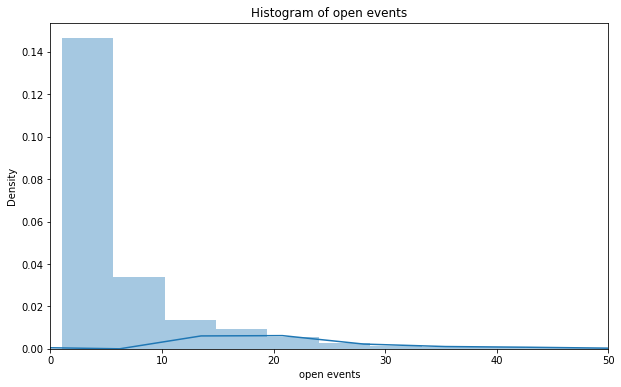

,qty_open_events
count,14006.00
mean,6.33
std,12.25
min,1.00
25%,1.00
50%,3.00
75%,7.00
95%,22.00
max,923.00


In [12]:
plt.figure(figsize=(10,6))
sns.distplot(df_open_events['qty_open_events'], bins=200)
plt.title('Histogram of open events')
plt.xlim(0,50)
plt.ylabel('Density')
plt.xlabel('open events')
plt.show()
df_open_events.describe(percentiles=[0.25,0.5, 0.75, 0.95])

### Customers have 6.33 events on average and 95% of the data have at least 22 events as we can see by the 95 percentile.

> it means that having customers with more than 22 open events is very unlikely to happen on this data.

**Note:** The max of 923 open events is very unlikely to happen and could be an <i>outlier</i> but it won't affect the final solution and it will be discussed in the next sections.

### Using <a href="https://en.wikipedia.org/wiki/Outlier#Tukey's_fences">Tukey's method </a> to consider outliers in data.

In [13]:
Q1 = np.percentile(df_open_events['qty_open_events'], 25)
Q3 = np.percentile(df_open_events['qty_open_events'], 75)
IQR =  Q3 - Q1
step = 1.5 * IQR
upper_limit = Q3 + step
lower_limit = Q1 - step

print('Customers with more than {0} open events or less than {1} are unlikely to happen \
according to these data'.format(upper_limit, lower_limit))

Customers with more than 16.0 open events or less than -8.0 are unlikely to happen according to these data


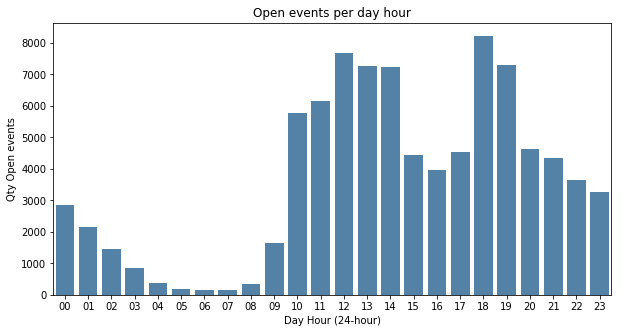

In [14]:
df_open_events = df_full_data[['event_hour','flg_open']][df_full_data['flg_open']==1].groupby(by=['event_hour']).sum()
df_open_events.reset_index(inplace=True)

plt.figure(figsize=(10,5))

df_open_events.columns = ['event_hour', 'qty_open_events']

sns.barplot(data=df_open_events,
               x='event_hour',
               y='qty_open_events',
               color='steelblue')


plt.grid('off')
plt.title('Open events per day hour')
plt.xlabel('Day Hour (24-hour)')
plt.ylabel('Qty Open events')
plt.show()

Visualizing the distribution of events "open" along the hours of the day, it's possible to identify some groups that could be used as reference to divide data into hours ranges. 

For example:

1. from 00 to 03 hours 
2. from 04 to 09 hours 
3. from 10 to 11 hours 
4. from 12 to 14 hours
5. from 15 to 17 hours
6. from 18 to 19 hours
7. from 20 to 23 hours


## Analysis Question 01 - Do open events follow the same behavior on <u>regular days</u> and <u>weekends</u>?

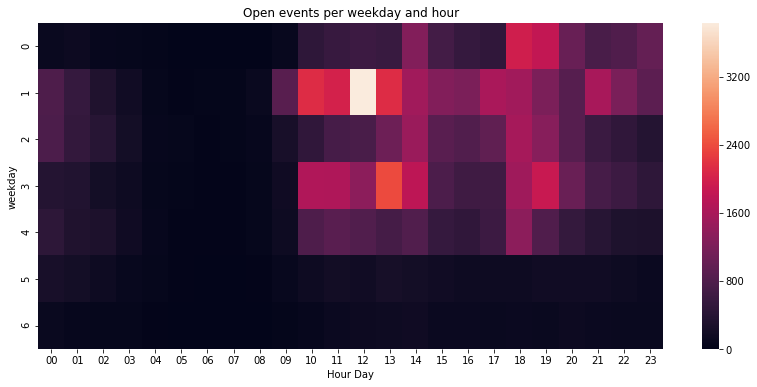

In [15]:
df_cohort_analysis = df_full_data[['weekday', 'event_hour', 'flg_open', 'flg_received']]. \
                    groupby(['weekday', 'event_hour']).sum().reset_index()
    
plt.figure(figsize=(14,6))
sns.heatmap(df_cohort_analysis.pivot_table(columns='event_hour', index='weekday', values='flg_open'))
plt.title('Open events per weekday and hour')
plt.xlabel('Hour Day')
plt.show()

#### The X-axis represents the day hours and the Y-axis the week days ( 0 = Monday ... 6 = Sunday). 

> There is a concentration from day 0 to 4 (Monday - Friday) with a clear contrast **from 10 to 13** on **Tuesdays** and **Thursdays**.

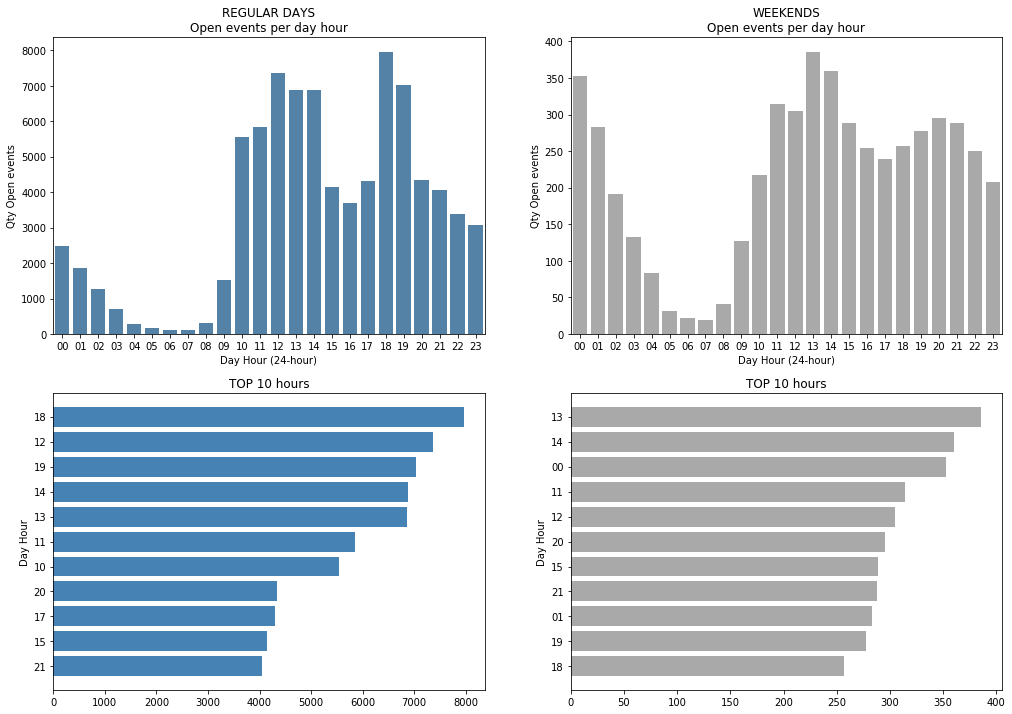

In [16]:
df_open_events = df_full_data[['event_hour','flg_open', 'flg_weekend']][df_full_data['flg_open']==1].groupby(by=['event_hour', 'flg_weekend']).sum()
df_open_events.reset_index(inplace=True)
print()

plt.figure(figsize=(17,12))


df_open_events.columns = ['event_hour', 'flg_weekend', 'qty_open_events']

plt.subplot(221)
sns.barplot(data=df_open_events[df_open_events['flg_weekend']==0],
               x='event_hour',
               y='qty_open_events',
               color='steelblue')

plt.grid('off')
plt.title('REGULAR DAYS\nOpen events per day hour')
plt.xlabel('Day Hour (24-hour)')
plt.ylabel('Qty Open events')


plt.subplot(222)
sns.barplot(data=df_open_events[df_open_events['flg_weekend']==1],
               x='event_hour',
               y='qty_open_events',
               color='darkgrey')

plt.grid('off')
plt.title('WEEKENDS\nOpen events per day hour')
plt.xlabel('Day Hour (24-hour)')
plt.ylabel('Qty Open events')



plt.subplot(223)
plt.title('TOP 10 hours')
plt.barh(data=df_open_events[df_open_events['flg_weekend']==0].sort_values(by='qty_open_events', ascending=False)[:11],
               width='qty_open_events',
               y='event_hour',
               color='steelblue')
plt.gca().invert_yaxis()
plt.ylabel('Day Hour')
plt.grid('off')


plt.subplot(224)
plt.title('TOP 10 hours')
plt.barh(data=df_open_events[df_open_events['flg_weekend']==1].sort_values(by='qty_open_events', ascending=False)[:11],
               width='qty_open_events',
               y='event_hour',
               color='darkgrey')
plt.gca().invert_yaxis()
plt.ylabel('Day Hour')
plt.grid('off')



plt.show()

#### We can notice that the most frequent hour has shifted from 18 to 13 on the weekends and some others hours such dawn time are also more frequent on the weekends. 

#### <u>It's expected to have some differences as people's routines often change during the weekend.</u>

 > ### <mark> Weekday is an important feature to consider on send time recommendation. </mark>

## Analysis Question 02 - Is the open time directly affected by the receive time?

The concentration of open events could be related to people usually opening their emails at the time they receive them, therefore let's analyze <u>receive</u> events and check whether the hypothesis of having more open events concentrated in specific times is due to the amount of emails received at this same time.

### 3.2 - Analyzing receive events

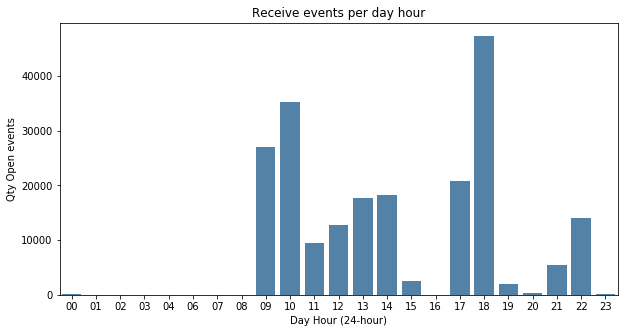

In [17]:
df_receive_events = df_full_data[['event_hour','flg_received']][df_full_data['flg_received']==1].\
                    groupby(by=['event_hour']).sum()
    
df_receive_events.reset_index(inplace=True)

plt.figure(figsize=(10,5))

df_receive_events.columns = ['event_hour', 'qty_receive_events']

sns.barplot(data=df_receive_events,
               x='event_hour',
               y='qty_receive_events',
               color='steelblue')
plt.grid('off')
plt.title('Receive events per day hour')
plt.xlabel('Day Hour (24-hour)')
plt.ylabel('Qty Open events')
plt.show()

#### In fact some concentrations are similar to the open events such as 18 and 10 hours but in general they are NOT following the same shape. 

In order to check other points before confirming that open events are related to people's behavior instead of receive time, two more tests might support this hypothesis: 
### **Correlation and average time between open and receive events**

> <u>If the hypothesis of people opening their emails at the moment they receive is true, correlation coefficient should be <span style="color:blue">**high**</span> and average time should be <span style="color:red">**low**</span> as the lower the time between open and receive time, the stronger the evidence in favor of receive time influencing open time.</u>

### 3.2.1 - Correlation between types of events

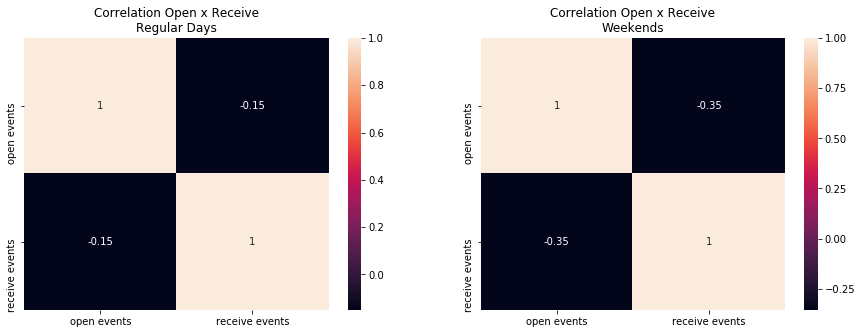

In [18]:
wknd_filter = df_full_data['flg_weekend'] == 1
corr_fields = ['id','flg_open', 'flg_received', 'event_hour']

df_correlation_week = df_full_data[corr_fields][~wknd_filter].groupby(['id', 'event_hour']).sum().reset_index()
df_correlation_wnd = df_full_data[corr_fields][wknd_filter].groupby(['id', 'event_hour']).sum().reset_index()

df_correlation_week.columns = ['id', 'event_hour', 'open events', 'receive events']
df_correlation_wnd.columns = ['id', 'event_hour', 'open events', 'receive events']

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Correlation Open x Receive\nRegular Days')

sns.heatmap(df_correlation_week.corr(), annot=True)

plt.subplot(122)
plt.title('Correlation Open x Receive\nWeekends')
sns.heatmap(df_correlation_wnd.corr(), annot=True)

plt.show()

### There is almost NO linear correlation between Open and Receive events according to the correlation matrices above. 

> For weekends the correlation is negatively stronger but still low.

### 3.2.2 - Average time between Open and Receive events

Another approach that can be used to measure the influence of receive time over open times is checking the Mean/Median of the difference between these two and check how close they are on average.
If this number is LOW (let's say until 2 hours), we can have some evidence to confirm this pattern.

In [0]:
#Only receive data
df_receive_events = df_full_data[df_full_data['flg_received'] == 1]

#Only open data
df_open_events = df_full_data[df_full_data['flg_open'] == 1]

#Preparing dataframes to join
df_receive_events = df_receive_events.set_index(['id', 'email_id'])
df_open_events = df_open_events.set_index(['id', 'email_id'])

In [0]:
#received + open events
df_open_received = df_receive_events.join(df_open_events, rsuffix='_open')

#Only data that we have the Open and Receive event for the same email+customer
df_open_received = df_open_received[df_open_received['timestamp_open'].notnull()]

In [21]:
print('We identified {0} cases with open and receive events for the same customer and email.'
.format(len(df_open_received.reset_index())))
      

We identified 88382 cases with open and receive events for the same customer and email.


In [0]:
#Converting data to timestamp in order to calculate the differeces
df_open_received['receivedtime_calc'] = df_open_received['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC"))
df_open_received['opentime_calc'] = df_open_received['timestamp_open'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S UTC"))

In [23]:
#Difference between open and receive time for the samme email and customer
delta = df_open_received['opentime_calc'] - df_open_received['receivedtime_calc']

#Describing the values
print('Median')
print(delta.median())

print('Max')
print(delta.max())

print('Min')
print(delta.min())

Median
0 days 04:20:32
Max
286 days 18:06:33
Min
-1 days +23:56:46


## Over more than 88k identified...

### Median of <mark> 4 hours and 20 min </mark> reinforces that open and receive time are NOT correlated, otherwise it will be closer.

#### Minimum with negative number might be an outlier and will be analyzed separately

#### Maximum of 286 days

### Negative cases

It is not possible to someone open an email before receive it, so it might be an error on data collecting process.
Let's remove those out from the analysis and check the numbers again

In [24]:
df_open_received_aux = df_open_received[df_open_received['receivedtime_calc'] <= df_open_received['opentime_calc']]
delta = df_open_received_aux['opentime_calc'] - df_open_received_aux['receivedtime_calc']

#Describing the values after removing outliers
print('Median')
print(delta.median())

print('Mean')
print(delta.mean())

print('Max')
print(delta.max())

print('Min')
print(delta.min())

Median
0 days 04:20:32.500000
Mean
2 days 22:15:10.205091
Max
286 days 18:06:33
Min
0 days 00:00:01


In [25]:
delta.describe().to_frame()

,0
count,88380
mean,2 days 22:15:10.205091
std,11 days 09:47:38.243731
min,0 days 00:00:01
25%,0 days 00:58:26
50%,0 days 04:20:32.500000
75%,1 days 00:42:01.250000
max,286 days 18:06:33


#### After removing those cases the minimum value was correct

### 3.3 - Hour range analysis

In order to group data into small groups and yet distinct enough to find different patterns, data will be analyzed in groups of two hours. 

In [0]:
def getHourRange(hra):
    
    hour_range= {'00': '00-01','01':'00-01','02':'02-03','03':'02-03','04':'04-05','05':'04-05','06':'06-07',
                 '07':'06-07','08':'08-09','09':'08-09','10':'10-11','11':'10-11','12':'12-13','13':'12-13',
                 '14':'14-15','15':'14-15','16':'16-17','17':'16-17','18':'18-19','19':'18-19','20':'20-21',
                 '21':'20-21','22':'22-23','23':'22-23'
                 }
    
    return hour_range.get(hra)

In [27]:
#Creating hour-range columns
df_full_data['hour_range'] = df_full_data['event_hour'].apply(lambda x: getHourRange(x))
df_full_data.head()

,id,timestamp,email_id,action,flg_open,flg_received,weekday,flg_weekend,event_time,event_hour,hour_range
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02 UTC,3498910,open,1,0,4,0,14:59:02,14,14-15
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23 UTC,3498910,open,1,0,0,0,17:47:23,17,16-17
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36 UTC,3498910,open,1,0,2,0,12:32:36,12,12-13
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28 UTC,3498910,open,1,0,0,0,22:47:28,22,22-23
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49 UTC,3498910,open,1,0,2,0,19:21:49,19,18-19


### Visualizing data grouped by hour range

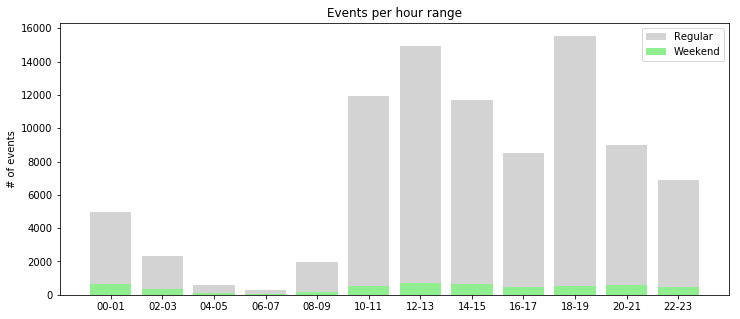

In [28]:
df_agg_data = df_full_data[['flg_open', 'hour_range', 'flg_weekend']].groupby(['hour_range', 'flg_weekend']).sum().reset_index()

plt.figure(figsize=(12,5))

plt.bar(height=df_agg_data['flg_open'][df_agg_data['flg_weekend']==0], 
        x=df_agg_data['hour_range'][df_agg_data['flg_weekend']==0],
       bottom=df_agg_data['flg_open'][df_agg_data['flg_weekend']==1],
       color='lightgrey',
       label='Regular')

plt.bar(height=df_agg_data['flg_open'][df_agg_data['flg_weekend']==1], 
        x=df_agg_data['hour_range'][df_agg_data['flg_weekend']==1],
       color='lightgreen',
       label='Weekend')


plt.xlabel('')
plt.legend()
plt.ylabel('# of events')
plt.title('Events per hour range')
plt.show()


> **The ranges 18-19 and 12-13 are the TOP 2 and it might indicate key hours to send email like rush and lunch time respectively for most people.**

## 4. Solution Design

Solution’s workflow designed to achieve the recommendations using history data and similar user’s information.

![solution_design](../miscellaneous/solution_workflow.png)

### For example...

By the people on the example figure above, the optimal time(s) to send an email to John would be:
1. The optimal time from John’s most probable cluster.
2. The optimal time from John’s **next** most probable cluster.
3. The optimal time from the next probable cluster of John’s
**similar users**.
4. The remaining probabilities of each time slot from John’s most
probable cluster.

> *** <font size=3> It is all about recommend time by similar people behavior and their own behavior </font>***

### 4.1 - Calculate similarity 

### How do we know that someone is similar to another with data?

If you are a person that usually open emails in the morning and lunch time, a similar user would be someone with the same preferences of time, so in order to identify similarities and group people, <u>the proportions of open emails along the time ranges will be used</u>

Therefore if 80% of John's emails are opened at 10 A.M in regular days, and the remaining 20% at 4 p.m and 7 p.m, the goal is to find people with similar habits and assign them in the same group that John's. 

### 4.2 - Clustering Algorithm

Clustering is basically group similar people within distinct groups so we can understand and guide our actions according to people's differences and similarities. In the context of this project, similar people would be the ones that usually have the same behavior related to the time of open emails. 

> ***For example, a given person that usually open his/her emails at 10 a.m and 8 p.m would be assigned to others with the same behavior, whereas people with a higher concentration of openings at 3 p.m will be in another group.***

There are some different approaches that we can use to cluster data and it will be discussed in the next sections.

### Hard x Soft Clustering

![soft_hard](../miscellaneous/soft_hard.png)

### Which one should be used for this project?

As Soft clustering algorithms return probabilities of a given customer belongs to any of the distinct groups, it has an important role on the proposed solution as it enables to capture different behavior for the same person as routines usually change due to external factors like vacations, night classes, etc. 

The probabilities outcomes will be used to **explore new time slots** in addition to the most probable cluster of each customer, so it will be able to suggest additional times from others clusters that a given person has the chance(probability > 0) to belong to.

### Gaussian Mixture Model

The most common definition of this algorithm is that a Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

It is like we assume that we have different density distributions in the same data and it tries to capture those differences.

![gmm_01](../miscellaneous/gmm_02.png)

**Further information on the following URLs:**
<li>https://scikit-learn.org/stable/modules/mixture.html
<li>https://brilliant.org/wiki/gaussian-mixture-model/
<li>https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

## 5. Solution Implementation

This project proposal is to use Machine Learning approaches recommending optimal email delivery times using user's preferences extracted from their past activities. This can be used in Customer Relationship Systems (CRM) to support marketers increasing email open rate and consequently reach more people in Digital Marketing campaigns

The solution implementation will cover three parts:

1. **Pre-process and format data**
2. **Applying Soft Cluster Algorithm**
3. **Recommendations in action**

### 5.1 - Pre-process and format data

As weekends and regular days are significantly different on people's open emails behavior, the analysis will be split in two datasets apart (one for weekends and other for regular days).

> Before recommending a certain optimal send time, the solution might consider checking the date target to use weekend or regular day recommendation.

In [0]:
#Getting open events data for each customer

#weekends
df_open_events_wknd = df_full_data[(df_full_data['flg_open'] == 1) & (df_full_data['flg_weekend'] == 1)]
df_open_agg_wknd = df_open_events_wknd[['id', 'hour_range', 'flg_open']].groupby(by=['id','hour_range']).sum()

#regular
df_open_events_reg = df_full_data[(df_full_data['flg_open'] == 1) & (df_full_data['flg_weekend'] == 0)]
df_open_agg_reg = df_open_events_reg[['id', 'hour_range', 'flg_open']].groupby(by=['id','hour_range']).sum()



In [0]:
#Getting total open events for each customer in order to calculate the proportions
total_customer_wknd = df_open_agg_wknd.pivot_table(index='id', values='flg_open', aggfunc=sum)
total_customer_reg = df_open_agg_reg.pivot_table(index='id', values='flg_open', aggfunc=sum)

In [31]:
total_customer_wknd.head()

,flg_open
id,
000c8d54dcdee43b7f76073ef2a83503402bc5a3,2
002d6764c373e63cc25c503d6d2cfccf3d953d22,2
003f350037c7bac0784e291b4c0cdfb7a79e67c2,3
003f3d2188e1412b5876837758c47e24ac5ab069,1
00439537448542c89f31ed747742ea8ca9d36c11,3


In [32]:
total_customer_reg.head()

,flg_open
id,
00009d30d2f6cdca3b306b6a0fe58a32e51dabdc,2
00074efe132b0b36c90ef600386ca2f863bc5e49,2
0009b0b413429e75bf81c8989d7c6201f2d86180,6
000e522c0071795551e9ebc958ea80be87d64ec3,3
001a8819c8fc79e60c8a580f78a6502b45d9206c,1


In [0]:
#Connecting customer events and total for the proportion calculation 
df_customers_wknd = df_open_agg_wknd.join(total_customer_wknd, rsuffix='_total')
df_customers_reg = df_open_agg_reg.join(total_customer_reg, rsuffix='_total')

In [34]:
df_customers_reg.head()

flg_open  flg_open_total
id                                       hour_range                          
00009d30d2f6cdca3b306b6a0fe58a32e51dabdc 12-13              1               2
                                         18-19              1               2
00074efe132b0b36c90ef600386ca2f863bc5e49 14-15              2               2
0009b0b413429e75bf81c8989d7c6201f2d86180 10-11              1               6
                                         12-13              2               6

In [35]:
#Calculating events proportion as customer's open events for each hour range / total of customer's open events
df_customers_wknd['open_prop'] = df_customers_wknd['flg_open'] / df_customers_wknd['flg_open_total']
df_customers_reg['open_prop'] = df_customers_reg['flg_open'] / df_customers_reg['flg_open_total']

#Setting data format to use them more easily on further clustering algorithm
df_customers_wknd = df_customers_wknd.pivot_table(index='id', columns='hour_range', values='open_prop', fill_value=0.0)
df_customers_reg = df_customers_reg.pivot_table(index='id', columns='hour_range', values='open_prop', fill_value=0.0)

df_customers_reg.head()

hour_range,00-01,02-03,04-05,06-07,08-09,10-11,12-13,14-15,16-17,18-19,20-21,22-23
id,,,,,,,,,,,,
00009d30d2f6cdca3b306b6a0fe58a32e51dabdc,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.50,0.00,0.00
00074efe132b0b36c90ef600386ca2f863bc5e49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
0009b0b413429e75bf81c8989d7c6201f2d86180,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.00,0.00,0.50,0.00,0.00
000e522c0071795551e9ebc958ea80be87d64ec3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.33,0.33,0.00,0.00
001a8819c8fc79e60c8a580f78a6502b45d9206c,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


After process the data we have one sparse matrix for each day type and each customer represented on the rows and the columns as the hour-ranges. 

Each cell represents the proportion of open events for a specific customer (row) and hour-range(column)

> **Note**: Working with proportions will be very handful as data will be well scaled and it is essential for math distance metrics used on clustering algorithm's calculations. Besides, the impact of outliers is reduced because data are being normalized with the total of events for each consumer, that is, a given person with 1K events for example can be compared easily with another one with only 3 events as their are scaled by the same unit (proportion) that varies from 0 to 1.

### 5.2 - Splitting Data into Train and Test datasets

For this solution we need to predict two things: 

1. A **cluster** to specific customer according to his/her data, in other words which group a "new" customer would fit better.
2. The **hour-range** to send an email for a specific customer and date.

First we need to build our clustering algorithm and this train and test datasets will be used to evaluate <u>**cluster prediction**</u> (item 1).

The solution's prediction (item 2) will be covered on the <u>Solution Evaluation</u> section

In [36]:
print('The dataset has {0} different customers on the "regular days" dataset and {1} on the weekends' \
      .format(len(df_customers_reg.index), len(df_customers_wknd.index)))

The dataset has 13724 different customers on the "regular days" dataset and 2410 on the weekends


We need to split these data into training and testing sets to evaluate the final algorithm. To do so, we consider a ratio of 80 to 20 percent each, so we need to extract a sample of 20% of the customers in each dataset.

### We can achieve this by randomly selecting customers ids from a given list of customers 

In [37]:
wknd_sample_size = int(len(df_customers_wknd.index) * 0.2)
reg_sample_size = int(len(df_customers_reg.index) * 0.2)

print('The test samples will have {0} customers from regular days and {1} customer from weekends dataset'\
     .format(reg_sample_size, wknd_sample_size))

The test samples will have 2744 customers from regular days and 482 customer from weekends dataset


### Getting the customer indexes to the test samples

In [0]:
wknd_test_sample = np.random.choice(df_customers_wknd.index, np.round(wknd_sample_size,0), replace=False)
reg_test_sample = np.random.choice(df_customers_reg.index, reg_sample_size, replace=False)

### Generating train and test datasets

In [0]:
df_wknd_test = df_customers_wknd.loc[wknd_test_sample]
df_reg_test = df_customers_reg.loc[reg_test_sample]

In [0]:
df_wknd_train = df_customers_wknd.reset_index()
df_wknd_train = df_wknd_train[~df_wknd_train['id'].isin(wknd_test_sample)]
df_wknd_train.set_index('id', inplace=True)

df_reg_train = df_customers_reg.reset_index()
df_reg_train = df_reg_train[~df_reg_train['id'].isin(reg_test_sample)]
df_reg_train.set_index('id', inplace=True)

### 5.3 - The Recommender - How does it work? 

In this section, the recommender will be detailed with examples and explanations step by step.

The first step is training a clustering algorithm, then use it to predict the cluster of a new customer according to his/her data and then use the defined rules to recommend the hour-range on a specific date.

### Step 01 -  How to choose the right number of clusters (components) to provide to the algorithm?

There are some techniques to guide the choice of cluster numbers of a given dataset. These techniques measure the algorithm's performance using N different clusters and show which number hit the best performance.

The method chosen was <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html'>Silhouette Score</a> which is a metric score with values from -1 to 1, being -1 the worse value and 1 the best for a certain number.

Let's figure out which one is the best score among a range of numbers like 2 to 12 (as we have an hour range for each two hours of the day and the maximum would be a cluster to each hour-range)

In [0]:
#from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
from sklearn.metrics.cluster import silhouette_score

#### Finding the best number of clusters according to the silhouette score

In [0]:
#Regular Days
scores_model = {}
for i in np.arange(2,30):
    cluster = gmm(n_components=i, random_state=42, covariance_type='spherical').fit(df_reg_train)
    pred = cluster.predict(df_reg_train)
    scores_model[i] = silhouette_score(df_reg_train, pred)
    

In [43]:
scores_model

{2: 0.255208831448996,
 3: 0.24392492064199034,
 4: 0.23941614051747437,
 5: 0.27374124064494143,
 6: 0.26909375651590683,
 7: 0.29513631105298094,
 8: 0.28794096047446244,
 9: 0.32505081246566986,
 10: 0.3019280516657007,
 11: 0.3206037971913949,
 12: 0.3432416646415239,
 13: 0.35160324393716863,
 14: 0.3665978591011592,
 15: 0.38107918784658973,
 16: 0.39450856052179634,
 17: 0.39897138259726533,
 18: 0.38243384881600057,
 19: 0.38824776348259354,
 20: 0.39623639457116094,
 21: 0.39715513602851704,
 22: 0.3892525158240271,
 23: 0.3906707638651571,
 24: 0.3895556733756678,
 25: 0.3834619844729687,
 26: 0.37890532945743977,
 27: 0.37702279642602915,
 28: 0.3971237909521599,
 29: 0.39792555938064583}

For **regular days** we can see the recommended cluster number according to Silhouette score.

Let's plot this and check how the score changed as the number of components increased

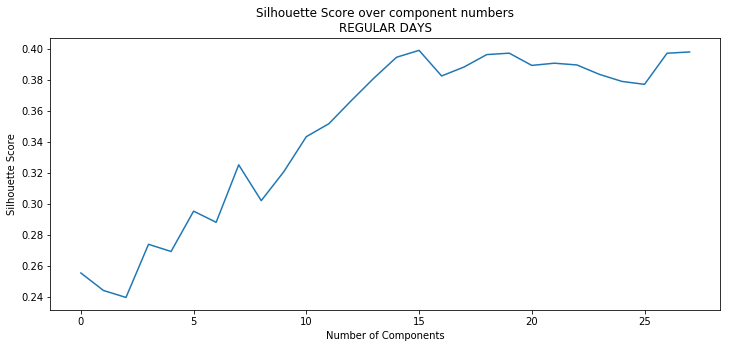

In [44]:
plt.figure(figsize=(12,5))
plt.title('Silhouette Score over component numbers\nREGULAR DAYS')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Components')
plt.plot(scores_model.values())
plt.show()

### Now let's perform the same analysis for weekends data

In [0]:
#Weekends
scores_model_wknd = {}
for i in np.arange(2,24):
    cluster_wknd = gmm(n_components=i, random_state=42, covariance_type='spherical').fit(df_wknd_train)
    pred_wknd = cluster_wknd.predict(df_wknd_train)
    scores_model_wknd[i] = silhouette_score(df_wknd_train, pred_wknd)

In [46]:

scores_model_wknd

{2: 0.192394564501698,
 3: 0.24596580290976583,
 4: 0.3247469385533447,
 5: 0.3904403911720325,
 6: 0.4310596306584932,
 7: 0.4843950351392938,
 8: 0.5102153764553586,
 9: 0.557642287572183,
 10: 0.5999545617372125,
 11: 0.6483257881665052,
 12: 0.6603320821496687,
 13: 0.6727383816132505,
 14: 0.6758960515821104,
 15: 0.6855090995578593,
 16: 0.6985126627417702,
 17: 0.7107881869841106,
 18: 0.7198932136130529,
 19: 0.723761558583514,
 20: 0.7316155016815572,
 21: 0.7378499224919375,
 22: 0.7417543607208241,
 23: 0.7468177638999451}

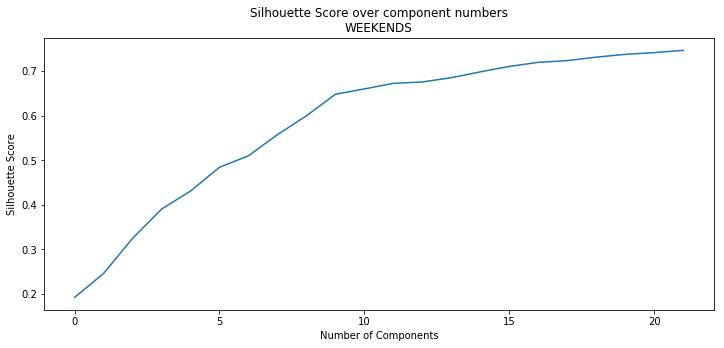

In [47]:
plt.figure(figsize=(12,5))
plt.title('Silhouette Score over component numbers\nWEEKENDS')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Components')
plt.plot(scores_model_wknd.values())
plt.show()

### Step 02 - Clustering Data

In [0]:
#Creating the classifiers (One for each type of day)
cluster_reg = gmm(n_components=15).fit(df_reg_train)
cluster_wknd = gmm(n_components=12).fit(df_wknd_train)


#Assigning cluster number to the customers of the training set
regularday_groups = cluster_reg.predict(df_reg_train)
weekend_groups = cluster_wknd.predict(df_wknd_train)

In [0]:
#Including cluster informatin within the datasets
df_reg_train['cluster'] = regularday_groups
df_wknd_train['cluster'] = weekend_groups

In [50]:
df_reg_train.head()

hour_range,00-01,02-03,04-05,06-07,08-09,10-11,12-13,14-15,16-17,18-19,20-21,22-23,cluster
id,,,,,,,,,,,,,
00074efe132b0b36c90ef600386ca2f863bc5e49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,8
0009b0b413429e75bf81c8989d7c6201f2d86180,0.00,0.00,0.00,0.00,0.00,0.17,0.33,0.00,0.00,0.50,0.00,0.00,10
000e522c0071795551e9ebc958ea80be87d64ec3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.33,0.33,0.33,0.00,0.00,3
001a8819c8fc79e60c8a580f78a6502b45d9206c,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9
0022c01e5b0850b7230f43ec05ab9b44131e5456,0.00,0.00,0.00,0.00,0.00,0.15,0.62,0.12,0.04,0.04,0.04,0.00,3


Let's check the outcomes with 3 examples of customers and their similarities

### Sample of customers from Cluster 0

In [51]:
df_reg_train[df_reg_train['cluster'] == 0][0:2]

hour_range,00-01,02-03,04-05,06-07,08-09,10-11,12-13,14-15,16-17,18-19,20-21,22-23,cluster
id,,,,,,,,,,,,,
002537444b11fc9d108662d182d482716d2a224b,0.00,0.00,0.00,0.00,0.07,0.14,0.07,0.21,0.07,0.07,0.21,0.14,0
003fdab6225466905f00dba748cff01a3b4fb90a,0.00,0.00,0.00,0.00,0.50,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0


### Sample of customers from Cluster 1

In [52]:
df_reg_train[df_reg_train['cluster'] == 1][0:1]

hour_range,00-01,02-03,04-05,06-07,08-09,10-11,12-13,14-15,16-17,18-19,20-21,22-23,cluster
id,,,,,,,,,,,,,
00439537448542c89f31ed747742ea8ca9d36c11,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.71,0.00,0.00,1


We can notice how much they differ from each other with concentrations of open rate in different hour ranges

Another efficient way to visualize the clusters behaviors is by the matrix below that shows the average proportion of each cluster over the hour ranges so we can check which are the main hour range(s) for each cluster, so the highlighted proportions with darker colors (columns) represent the best hour-range for the cluster in the row.

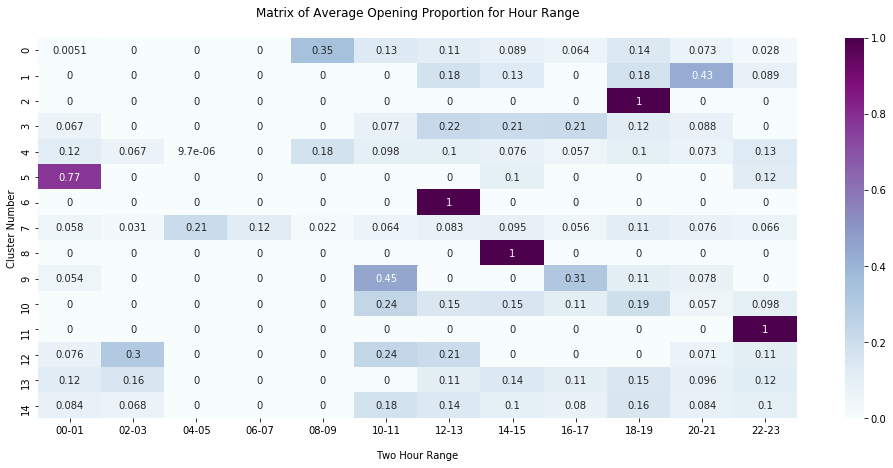

In [53]:
fig, ax = plt.subplots(figsize=(17,7))
cluster_table = df_reg_train.pivot_table(index='cluster')
sns.heatmap(cluster_table, ax=ax, annot=True, cmap='BuPu')
plt.title('Matrix of Average Opening Proportion for Hour Range\n')
plt.ylabel('Cluster Number')
plt.xlabel('\nTwo Hour Range')
plt.show()

### Step 03 - Send Time Recommendation

Simulating a real world application of this model, we have customer historical data and need to recommend an hour range to send an email in a specific date. So let's get a random customer from test data

In [0]:
random_customer_index = np.random.choice(len(df_reg_test)-1)
example_customer_data = df_reg_test.iloc[random_customer_index]

In [55]:
example_customer_data.to_frame()

,e163ad42079a0e47c2a031886f83c89eb45bb12f
hour_range,
00-01,0.00
02-03,0.00
04-05,0.00
06-07,0.00
08-09,0.00
10-11,0.00
12-13,0.00
14-15,0.00
16-17,0.00


Checking which cluster the model would assign to this customer using `predict_proba` method. It will show how this customer fits into the general model of regular day

> For example purposes we using only the regular day cluster. The recommender should evaluate which model to use by the target date

In [0]:
example_probs = cluster_reg.predict_proba(example_customer_data.values.reshape(1,-1))

In [57]:
np.set_printoptions(precision=10, suppress=True)
data_aux = []
for i in zip(range(15),example_probs[0]):
    data_aux.append(i)
data_aux  

[(0, 1.902083893764943e-18),
 (1, 0.9999980231961628),
 (2, 0.0),
 (3, 1.7357398461378067e-14),
 (4, 8.316564972578967e-31),
 (5, 0.0),
 (6, 0.0),
 (7, 9.233798305561727e-26),
 (8, 0.0),
 (9, 1.9767486522345688e-06),
 (10, 1.6718906752753602e-23),
 (11, 0.0),
 (12, 5.5167524600080645e-11),
 (13, 4.662447665582307e-17),
 (14, 1.4236958338325564e-28)]

In [58]:
prob_cluster = np.argsort(-example_probs)[0][0]
next_cluster = np.argsort(-example_probs)[0][1]
print('The most probable cluster for this customer is {0} and next most probable is {1}' \
      .format(prob_cluster, next_cluster))


The most probable cluster for this customer is 1 and next most probable is 9


Now we need to extract the next most probable cluster from similar users to this example customer.

Let's first get people from the same cluster (similar users) and use `predict_proba` method again to get all the probabilities for each customer.

In [59]:
print('People similar to the example customer')
df_reg_train[df_reg_train['cluster']== prob_cluster].head()

People similar to the example customer


hour_range,00-01,02-03,04-05,06-07,08-09,10-11,12-13,14-15,16-17,18-19,20-21,22-23,cluster
id,,,,,,,,,,,,,
00439537448542c89f31ed747742ea8ca9d36c11,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.00,0.71,0.00,0.00,1
00514084cf11175e49589c542b6f358eb3895041,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,0.00,1
005c56a6afec10a516262dd0c699d224579c377c,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.60,0.00,0.00,0.00,0.00,1
0076342d948f61dab2016514809e322a7d4cbb3e,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,0.00,1
00c47a9d70ef6f57f1bce784b7a5471b868be6d7,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.50,1


In [0]:
#Getting similar customers probabilities 
example_pred = cluster_reg.predict_proba(df_reg_train[df_reg_train['cluster']== prob_cluster].values[:, :12])

> In order to get only the features needed on the prediction method we don't have to pass the column named  "cluster"" and it will be removed from the prediction

Now that we have a set of cluster probabilities for each similar customer we need to get the most probable <mark>next</mark> cluster like we did in above example using `numpy argsort` method. 

***The most frequent next cluster will be chosen***

In [61]:
example_freq_table = pd.DataFrame(np.argsort(-example_pred)[:,1], columns=['freq'])['freq'].value_counts().to_frame()
example_freq_table

,freq
9,654
10,532
3,393
12,274
13,1


With the table above the most frequent next cluster is the one at the TOP, so the row index will be the chosen cluster in recommendation

In [0]:
next_similar_cluster = example_freq_table.iloc[0].name

### Finally we have the three clusters that will be the base of recommendations,.

now we just have to get their hour ranges

In [63]:
print('Example Cluster: {0}'.format(prob_cluster))
print('Next Cluster: {0}'.format(next_cluster))
print('Next Similar Cluster: {0}'.format(next_similar_cluster))

Example Cluster: 1
Next Cluster: 9
Next Similar Cluster: 9


In [64]:
recommended_clusters = [prob_cluster,next_cluster,next_similar_cluster]
cluster_table.loc[recommended_clusters]

hour_range,00-01,02-03,04-05,06-07,08-09,10-11,12-13,14-15,16-17,18-19,20-21,22-23
cluster,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.18,0.13,0.00,0.18,0.43,0.09
9,0.05,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.31,0.11,0.08,0.00
9,0.05,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.31,0.11,0.08,0.00


### Which hour range would be the best recommendation?

To recommend an optimal send time for this customer and also explore new time slots, the maximum column (which represents the hour range) of each cluster (row) will be used as the most probable hour ranges.

In [0]:
column_array = cluster_table.loc[recommended_clusters].values.argmax(axis=1)

In [0]:
#Creating the final probabilities table
probs_recommendation = []

for i in range(len(cluster_table.iloc[recommended_clusters[0]])):
    probs_recommendation.append((i, cluster_table.iloc[recommended_clusters[0]][i]))

In [67]:
print('This is an example of the hour range probabilities table')
print()
final_table_prob = pd.DataFrame(probs_recommendation, columns=['hour', 'prob']).set_index('hour')
final_table_prob

This is an example of the hour range probabilities table



,prob
hour,
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
5,0.00
6,0.18
7,0.13
8,0.00


In [68]:
#Updating the probabilities of recommended hour ranges
for i in range(3):
    actual_value = final_table_prob.iloc[column_array[i]][0]
    new_value = cluster_table.iloc[recommended_clusters[i]][column_array[i]]
    if new_value > actual_value:
        final_table_prob.iloc[column_array[i]] = cluster_table.iloc[recommended_clusters[i]][column_array[i]]
        
print('This is the updated table of example customer cluster')
print()
final_table_prob

This is the updated table of example customer cluster



,prob
hour,
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
5,0.45
6,0.18
7,0.13
8,0.00


In [69]:
final_table_prob.reset_index().pivot_table(columns='hour', values='prob')

hour,0,1,2,3,4,5,6,7,8,9,10,11
prob,0.00,0.00,0.00,0.00,0.00,0.45,0.18,0.13,0.00,0.18,0.43,0.09


The probability table must sum to 1 in order to pass it as parameter to `numpy.random.choice` function. This function will be used to randomly select the hour range given the probabilities so it can recommend and explore new time slots. 

Therefore this data can be normalized dividing them by the sum of proportions as follows:

In [70]:
probs = list(final_table_prob['prob'] / final_table_prob['prob'].sum())

print('Final probability table')
pd.DataFrame([probs])

Final probability table


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.00,0.00,0.00,0.00,0.00,0.31,0.12,0.09,0.00,0.12,0.30,0.06


## Recommender in action

In [71]:
recommended = np.random.choice(final_table_prob.index, p=probs)
print('A suggested hour range for this customer would be {0}'.format(cluster_table.columns[recommended]))

A suggested hour range for this customer would be 18-19


> If we run this enough times we can see the results would follow the probabilities table.

#### Those functions will be implemented in a separate file called `recommender.py` to make it easier to automate the process in the future. 

## 6 - Solution Evaluation

Evaluate the model results is as important as creating it so we can check whether it is worth spending time and resources on it. Besides, it has to be better than a baseline solution to justify its effort.

### What is a baseline model?

Baseline model is the simplest way to solve the proposed problem that we can use as a benchmark, for example in our case what if we simply send emails at the most frequent customer's open times? Would it have a better or worse result compared to our model?

This approach is a good guide to give an idea of what is a good result? 
So to confirm (or not) the solution feasibility, its results must be better than this baseline solution, otherwise we just need to implement this "easy" part.


## How can we measure it?


The real way to measure it is by using the optimized solution in a controlled environment/experiment and then compare the results with and without the recommendations, so it can be evaluated whether the difference is significant enough to conclude a real improvement. 

In this specific case we have email Open Rate metric from Digital Marketing Campaigns attached to this process, so we can prove the hypothesis of:<br><br>

**H0:** Email open rate won't be changed significantly by optimizing send time.<br>
**HA:** Sending emails at the right time for customers will increase open rate. 

There is no way to deploy this model in a production environment for test purpose but it's possible to simulate a recommendation by using the model's predictions and compare with open events that we have in the data.


### <a href='https://en.wikipedia.org/wiki/F1_score'>F1-Score</a> will be the base for comparisons 

it's a valid metric for multiclass classifications (and the hour-range will be considered a class in the prediction phase) with average parameter set to "micro" to work with the overall right predicted classes and prevent any problem with imbalanced classes like 4-5 a.m with very few open events while most concentrated at dinner and rush times as we noticed earlier in the exploratory analysis.


### Benchmark model

In order to create the baseline model benchmark we are going to get the most frequent open times for each customer and measure the accuracy of this (dummy) model in a sample from open events, so we can compare to the recommender accuracy and check which one is better.

In [0]:
#base line model function
df_open_aux = df_open_events_reg[['id', 'flg_open', 'flg_weekend', 'hour_range']].reset_index()

def getMostFrequent(customer_id, flg_weekend, df_train):
    
    open_aux = df_train[(df_train['id']==customer_id) & (df_train['flg_weekend']==flg_weekend)]
    if len(open_aux) > 0:
        return open_aux.sort_values('flg_open', ascending=False)[:1]['hour_range'].values[0]
    else:#most frequent hour range for the given day type
        return df_train['hour_range'][df_train['flg_weekend']==flg_weekend].value_counts().index[0] 

In [73]:
#Example...
getMostFrequent('02d4de432ed73064f261499c677f1699b4c48b55', 0, df_open_aux)

'12-13'

## Validation dataset

The test data that will be used to validate the algorithm will be data from the last month, so we can predict unseen data in future dates simulating how it will work in a real situation (Suggesting send time to future dates)

In [0]:
df_evaluate_data = df_full_data[(df_full_data['flg_open']==1)]

df_evaluate_data['event_month'] = df_evaluate_data['timestamp'].apply(lambda x: x[5:7])

In [75]:
df_evaluate_data['event_month'].value_counts()

11    20265
10    17389
08     9354
05     9343
06     7875
09     6455
07     6322
04     4951
02     2684
01     2088
03     1873
Name: event_month, dtype: int64

***There are enough data to test the results on the last month (11 = November) as we can see by the data above***

In [0]:
#Splitting data into train and test sets
df_eval_test = df_evaluate_data[df_evaluate_data['event_month'] == '11'].sample(1000)
df_eval_train = df_evaluate_data[~(df_evaluate_data['event_month'] == '11')]

In [0]:
## Predicting cases with dummy model
dummy_pred = []
for i in range(len(df_eval_test)):
    dummy_pred.append(getMostFrequent(df_eval_test['id'].iloc[i], 
                                      df_eval_test['flg_weekend'].iloc[i], 
                                      df_eval_train)) 
    
    
df_eval_test['dummy_pred'] = dummy_pred

In [0]:
df_eval_test['dummy_pred_bool'] = df_eval_test['hour_range'] == df_eval_test['dummy_pred']

df_eval_test['acc_dummy_pred'] = df_eval_test['dummy_pred_bool'].apply(lambda x: 1 if x else 0)

In [0]:
dummy_accuracy = df_eval_test['acc_dummy_pred'].sum() / len(df_eval_test)

In [80]:
print('We have an accuracy of {0:.2%}\
 using the dummy model and this is the minimum we could reach in the simplest way.'.format(dummy_accuracy))

We have an accuracy of 14.10% using the dummy model and this is the minimum we could reach in the simplest way.


### Recommender Evaluation

The recommender file a class named `SentTimeRecommender` with all the methods needed to the recommendation process and it will be used from now on in recommendations tasks

In [0]:
from recommender import SendTimeRecommender
sendtimeRecommender = SendTimeRecommender('sto_challenge.csv')

In [0]:
df_eval_train_2 = sendtimeRecommender.set_additional_columns(df_eval_train)

In [83]:
df_eval_train_2.head()

,id,timestamp,email_id,action,flg_open,flg_received,weekday,flg_weekend,event_time,event_hour,hour_range,event_month,event_date,day_type
0,4591b11ba8cca67079c1a43be2992a8f89fce422,2018-05-25 14:59:02 UTC,3498910,open,1,0,4,0,14:59:02,14,14-15,05,2018-05-25,0
1,2bbdb4cff0fe8cc3cb6c1757291e31806ecefa47,2018-06-25 17:47:23 UTC,3498910,open,1,0,0,0,17:47:23,17,16-17,06,2018-06-25,0
2,0f467135eabd4e385f9c2dcd3f00a9f2a04c0115,2018-06-27 12:32:36 UTC,3498910,open,1,0,2,0,12:32:36,12,12-13,06,2018-06-27,0
3,6f17b7dc6f220c09fba4d8fbc2491317eece2ae8,2018-07-02 22:47:28 UTC,3498910,open,1,0,0,0,22:47:28,22,22-23,07,2018-07-02,0
4,a645dd2ac5c5e000c8b5c7739b3a54435fb313cc,2018-01-24 19:21:49 UTC,3498910,open,1,0,2,0,19:21:49,19,18-19,01,2018-01-24,0


In [84]:
#Trainning the model is the process of clustering creating (one for weekend and another one for regular days)
sendtimeRecommender.train(df_eval_train_2)

Time to train: 114.61310243606567


In [0]:
def getdaytype(weekday):
  if weekday in (0,2,4):
    return 0
  elif weekday in (1,3):
    return 1
  else:
    return 2

In [0]:
df_eval_test['event_date'] = df_eval_test['timestamp'].apply(lambda x: x[:10])
df_eval_test['day_type'] = df_eval_test['weekday'].apply(lambda x: getdaytype(x))

For the same customer used as example in above section when testing the dummy model function, this model should recommend (most of the time) the customer's most frequent time which often has greater probability as it might be the cluster greater value.

Let's check the model out

In [87]:
#Example...
for i in range(10):
    print(sendtimeRecommender.recommend_send_time('02d4de432ed73064f261499c677f1699b4c48b55',
                                          '2019-03-25', learning_rate=0.05))
    

(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')
(6, '12-13')


This actually has the majority of recommendations on customer's most frequent time.

What if we change the learning rate a little bit?

### Learning Rate parameter: This parameter controls how much we want this model to "learn" 

<mark><u>Learning in this context means the exploration of new time slots</u></mark>

> **Note:** This metric is inversely proportional to the probabilities of getting the most frequent hour range of the user, therefore The higher this number, the more this model will learn from new time slots so we can balance this parameter according to our needs.

In [88]:
#Example...
for i in range(10):
    print(sendtimeRecommender.recommend_send_time('02d4de432ed73064f261499c677f1699b4c48b55',
                                          '2019-03-25', learning_rate=0.5))

(0, '00-01')
(0, '00-01')
(11, '22-23')
(6, '12-13')
(11, '22-23')
(7, '14-15')
(8, '16-17')
(6, '12-13')
(5, '10-11')
(6, '12-13')


Now we can see it varies a little bit but still has some recommendations on the most frequent time! 

### So that's how this model is supposed to work! 

#### Now the model will be tested on more data to evaluate its results

In [0]:
#Function to predict a hour-range for each customer

def predictSendTime(recommender, test_set, learning_rate): 

    start = time.time()

    model_pred = []
    for i in range(len(df_eval_test)):
        cluster, predicted_sendtime = recommender.recommend_send_time(test_set['id'].iloc[i], 
                                                                            test_set['event_date'].iloc[i], 
                                                                            learning_rate=learning_rate)

        model_pred.append(predicted_sendtime) 


    end = time.time()

    print('Time to predict: {0}'.format(end-start))
    
    return model_pred

In [90]:
model_pred = predictSendTime(sendtimeRecommender, df_eval_test, 0.05)

df_eval_test['model_pred'] = model_pred

Time to predict: 224.73523783683777


In [0]:
df_eval_test['rcc_pred_bool'] = df_eval_test['hour_range'] == df_eval_test['model_pred']

df_eval_test['acc_recom_pred'] = df_eval_test['rcc_pred_bool'].apply(lambda x: 1 if x else 0)

recommender_accuracy = df_eval_test['acc_recom_pred'].sum() / len(df_eval_test)

In [92]:
print('We have an accuracy of {0:.2%} using the recommender model which is higher than\
 dummy model'.format(recommender_accuracy))

We have an accuracy of 55.00% using the recommender model which is higher than dummy model


In [93]:
pct_equal_pred = np.sum((df_eval_test['dummy_pred_bool']) & (df_eval_test['rcc_pred_bool'])) / len(df_eval_test)

print('{0:.2%} of the right predictions\
 from recommender model was also predicted\
 right from the most frequent approach'.format(pct_equal_pred))


print('Thus about {0:.2%} of test data was actually predicted\
 by recommendations'.format(recommender_accuracy - pct_equal_pred) )

9.50% of the right predictions from recommender model was also predicted right from the most frequent approach
Thus about 45.50% of test data was actually predicted by recommendations


>  An **interesting** find here is that over the right predictions from recommendation model, only a **small** percentage was the same as the previous approach, meaning that <u>exploration and exploitation might help to get right at send times different than the most frequent ones</u>.

## F1-Score - Evaluating model recommendations

In [0]:
from sklearn.metrics import f1_score

In [95]:
print('F1 Score for recommender predictions')
print(f1_score(df_eval_test['hour_range'], df_eval_test['model_pred'], 
               average='micro'))

F1 Score for recommender predictions
0.55


In [96]:
print('F1 Score for dummy model predictions')
print(f1_score(df_eval_test['hour_range'], df_eval_test['dummy_pred'], 
               average='micro'))

F1 Score for dummy model predictions
0.141


### Covariance Type: Testing with other cluster parameters
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

![covariance_type](../miscellaneous/covariance_type.png)

## full 

Each component has its own general covariance matrix

In [97]:
sendtimeRecommender.train(df_eval_train_2, covariance_type='full')

Time to train: 170.8161334991455


In [98]:
model_pred_fullcov = predictSendTime(sendtimeRecommender, df_eval_test, 0.05)

df_eval_test['model_pred_fullcov'] = model_pred_fullcov

Time to predict: 256.15272784233093


In [99]:
print('F1 Score for recommender predictions for FULL Covariance Type')
print(f1_score(df_eval_test['hour_range'], df_eval_test['model_pred_fullcov'], 
               average='micro'))

F1 Score for recommender predictions for FULL Covariance Type
0.38


## tied: 
all components share the same general covariance matrix

In [100]:
sendtimeRecommender.train(df_eval_train_2, covariance_type='tied')

Time to train: 136.30418872833252


In [101]:
model_pred_tied = predictSendTime(sendtimeRecommender, df_eval_test, 0.05)

df_eval_test['model_pred_tied'] = model_pred_tied

Time to predict: 267.89624071121216


In [102]:
print('F1 Score for recommender predictions for TIED Covariance Type')
print(f1_score(df_eval_test['hour_range'], df_eval_test['model_pred_tied'], 
               average='micro'))

F1 Score for recommender predictions for TIED Covariance Type
0.553


## diag: 

each component has its own diagonal covariance matrix

In [103]:
sendtimeRecommender.train(df_eval_train_2, covariance_type='diag')

Time to train: 120.60455417633057


In [104]:
model_pred_diag = predictSendTime(sendtimeRecommender, df_eval_test, 0.05)

df_eval_test['model_pred_diag'] = model_pred_diag

Time to predict: 267.6662104129791


In [105]:
print('F1 Score for recommender predictions for DIAG Covariance Type')
print(f1_score(df_eval_test['hour_range'], df_eval_test['model_pred_diag'], 
               average='micro'))

F1 Score for recommender predictions for DIAG Covariance Type
0.37899999999999995


## spherical 

each component has its own single variance

In [106]:
sendtimeRecommender.train(df_eval_train_2, covariance_type='spherical')

Time to train: 114.5159113407135


In [107]:
model_pred_sph = predictSendTime(sendtimeRecommender, df_eval_test, 0.05)

df_eval_test['model_pred_sph'] = model_pred_sph

Time to predict: 272.22368836402893


In [108]:
print('F1 Score for recommender predictions for SPHERICAL Covariance Type')
print(f1_score(df_eval_test['hour_range'], df_eval_test['model_pred_sph'], 
               average='micro'))

F1 Score for recommender predictions for SPHERICAL Covariance Type
0.549


In [0]:
pred_columns = ['model_pred_fullcov', 'model_pred_tied', 'model_pred_diag', 
                'model_pred_sph']
cov_types = ['full', 'tied', 'diag', 'spherical']

cluster_scores = {}
for i in range(len(pred_columns)):
    cluster_scores[cov_types[i]] = [f1_score(df_eval_test['hour_range'], 
                                            df_eval_test[pred_columns[i]], 
                                            average='micro')]
    

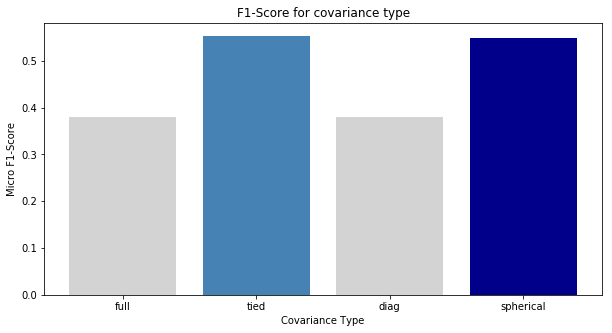

In [110]:
score_chart = pd.DataFrame(cluster_scores)

plt.figure(figsize=(10,5))
plt.bar( x='full',height=score_chart['full'][0], color='lightgrey')
plt.bar( x='tied',height=score_chart['tied'][0], color='steelblue')
plt.bar( x='diag',height=score_chart['diag'][0], color='lightgrey')
plt.bar( x='spherical',height=score_chart['spherical'][0], color='darkblue')

plt.title('F1-Score for covariance type')
plt.ylabel('Micro F1-Score')
plt.xlabel('Covariance Type')
plt.show()


> #### We can see that full is not the best parameter and with `spherical` or `diag` covariance types we had the best scores and the lowest training times. 

### What if the learning rate was lower (in other words benefit exploitation over exploration)?

In [111]:
model_pred_lower = predictSendTime(sendtimeRecommender, df_eval_test, 0.001)

df_eval_test['model_pred_lower'] = model_pred_lower

Time to predict: 278.06527757644653


In [0]:
df_eval_test['rcc_pred_bool_low'] = df_eval_test['hour_range'] == df_eval_test['model_pred_lower']

df_eval_test['acc_recom_pred_low'] = df_eval_test['rcc_pred_bool_low'].apply(lambda x: 1 if x else 0)

recommender_accuracy_lower = df_eval_test['acc_recom_pred_low'].sum() / len(df_eval_test)

In [113]:
print('We have an accuracy of {0:.2%}\
 using the recommender model with lower learning rate'.format(recommender_accuracy_lower))

We have an accuracy of 57.60% using the recommender model with lower learning rate


In [114]:
print('F1 Score for recommender predictions')
print(f1_score(df_eval_test['hour_range'], df_eval_test['model_pred_lower'], average='micro'))

F1 Score for recommender predictions
0.576


### We had a slightly change on the score using a lower learning rate but even so, we should keep this parameter with a considerable rate of learning 

> It will contribute to the recommender improvement in the future since it will be able to update its data with new information regularly and still keep the accuracy stable

## ROC AUC for Multiclass predictions

In order to evaluate another common metric widely used on classification problems and check our recommender's performance in a different perspective, let's check how the model behaves with <a href='https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5'>ROC AUC metric</a>.

> In this score the values varies from 0.0 to 1.0, being that the higher the number the best the model can distinguish between classes.

In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

In [116]:
print('AUC with recommendation method')
lb = LabelBinarizer()
lb.fit(df_eval_test['hour_range'])
y_test = lb.transform(df_eval_test['hour_range'])
y_pred = lb.transform(df_eval_test['model_pred_lower'])
roc_auc_score(y_test, y_pred, average='micro')

AUC with recommendation method


0.7687272727272728

In [0]:
df_eval_test['numrec'] = 1

conf_matrix = df_eval_test[['hour_range', 'model_pred_lower','numrec']].groupby(['hour_range', 
                                                                                 'model_pred_lower']).sum()
conf_matrix = conf_matrix.reset_index().pivot_table(index='hour_range',
                                                  columns='model_pred_lower', 
                                                  values='numrec').fillna(0)

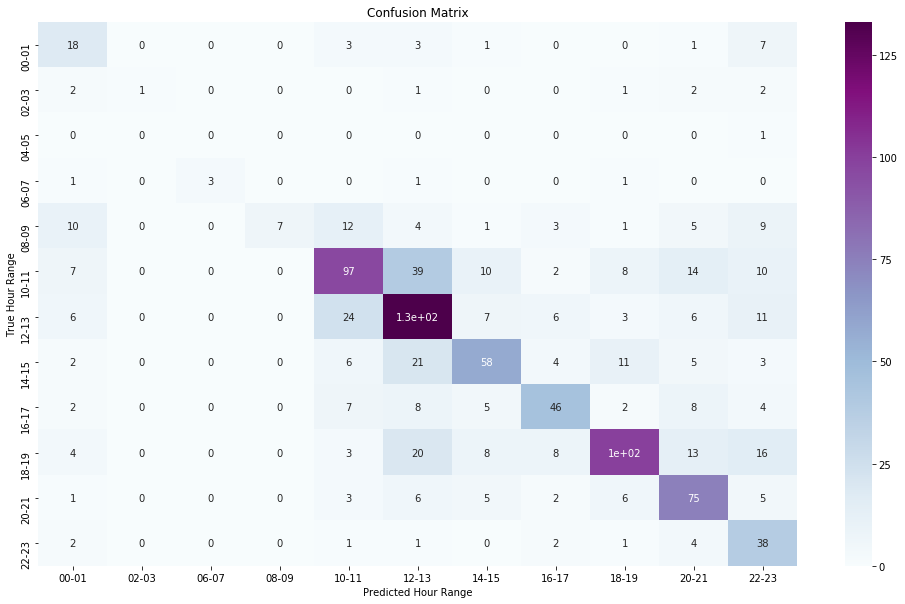

In [118]:
plt.figure(figsize=(17,10))
sns.heatmap(conf_matrix, cmap='BuPu', annot=True)
plt.title('Confusion Matrix')
plt.ylabel('True Hour Range')
plt.xlabel('Predicted Hour Range')
plt.show()

For the matrix above it is possible to check which are the top hour ranges the model correctly predicted and which are the ranges that it got wrong the most so we can analyze this deeply later and check for improvements points (like the difficult to suggest rare hour ranges)

## 7 - Sensitivity Analysis

In order to validate the robustness and uncertainty level of the results, let's perform a **sensitivity analysis** which consists in calculating the solution performance in many different test sets and see how the model is affected.

The dataset contains data from January to November 2018 and in the first test phase, November data was used as test sets simulating a real world application where it will need to predict future send times using past user's data. 

So this logic will be used again with different tests sets like:

1. Training set with data from January to September and test with October and November data
2. Training set with data from January to August and test set with the remaining

In [0]:
#Splitting data into train and test sets
df_eval_test_oct_nov = df_evaluate_data[df_evaluate_data['event_month'].astype(int) > 9].sample(1000)
df_eval_train_jan_sep = df_evaluate_data[df_evaluate_data['event_month'].astype(int) <= 9]

df_eval_test_oct_nov['event_date'] = df_eval_test_oct_nov['timestamp'].apply(lambda x: x[:10])
df_eval_test_oct_nov['day_type'] = df_eval_test_oct_nov['weekday'].apply(lambda x: getdaytype(x))
df_eval_train_jan_sep['day_type'] = df_eval_train_jan_sep['weekday'].apply(lambda x: getdaytype(x))

In [120]:
sendtimeRecommender.train(df_eval_train_jan_sep, covariance_type='spherical')

Time to train: 66.33328413963318


In [121]:
model_pred_oct_nov = predictSendTime(sendtimeRecommender, df_eval_test_oct_nov, 0.005)

df_eval_test_oct_nov['model_pred_oct_nov'] = model_pred_oct_nov

Time to predict: 235.13728094100952


In [122]:
print('F1 Score for recommender predictions using data from JAN - SEP in training phase')
print(f1_score(df_eval_test_oct_nov['hour_range'], df_eval_test_oct_nov['model_pred_oct_nov'], average='micro'))

F1 Score for recommender predictions using data from JAN - SEP in training phase
0.566


In [0]:
## Predicting cases with dummy model
dummy_pred = []
for i in range(len(df_eval_test)):
    dummy_pred.append(getMostFrequent(df_eval_test_oct_nov['id'].iloc[i], 
                                      df_eval_test_oct_nov['flg_weekend'].iloc[i], 
                                      df_eval_train_jan_sep)) 
    
    
df_eval_test_oct_nov['dummy_pred'] = dummy_pred

In [124]:
print('F1 Score for dummy model using data from JAN - SEP in training phase')
print(f1_score(df_eval_test_oct_nov['hour_range'], df_eval_test_oct_nov['dummy_pred'], average='micro'))

F1 Score for dummy model using data from JAN - SEP in training phase
0.15


In [0]:
#Splitting data into train and test sets
df_eval_test_sep_nov = df_evaluate_data[df_evaluate_data['event_month'].astype(int) > 8].sample(1000)
df_eval_train_jan_aug = df_evaluate_data[df_evaluate_data['event_month'].astype(int) <= 8]

df_eval_test_sep_nov['event_date'] = df_eval_test_sep_nov['timestamp'].apply(lambda x: x[:10])
df_eval_test_sep_nov['day_type'] = df_eval_test_sep_nov['weekday'].apply(lambda x: getdaytype(x))
df_eval_train_jan_aug['day_type'] = df_eval_train_jan_aug['weekday'].apply(lambda x: getdaytype(x))

In [126]:
sendtimeRecommender.train(df_eval_train_jan_aug, covariance_type='spherical')

Time to train: 58.50751757621765


In [127]:
model_pred_sep_nov = predictSendTime(sendtimeRecommender, df_eval_test_sep_nov, 0.005)

df_eval_test_sep_nov['model_pred_sep_nov'] = model_pred_sep_nov

Time to predict: 229.42460918426514


In [128]:
print('F1 Score for recommender predictions using data from JAN - AUG in training phase')
print(f1_score(df_eval_test_sep_nov['hour_range'], df_eval_test_sep_nov['model_pred_sep_nov'], average='micro'))

F1 Score for recommender predictions using data from JAN - AUG in training phase
0.547


In [0]:
## Predicting cases with dummy model
dummy_pred = []
for i in range(len(df_eval_test)):
    dummy_pred.append(getMostFrequent(df_eval_test_sep_nov['id'].iloc[i], 
                                      df_eval_test_sep_nov['flg_weekend'].iloc[i], 
                                      df_eval_train_jan_aug)) 
    
    
df_eval_test_sep_nov['dummy_pred'] = dummy_pred

In [130]:
print('F1 Score for dummy model using data from JAN - AUG in training phase')
print(f1_score(df_eval_test_sep_nov['hour_range'], df_eval_test_sep_nov['dummy_pred'], average='micro'))

F1 Score for dummy model using data from JAN - AUG in training phase
0.161


### Comparing Baseline and Recommender results with different sets

In [0]:
benchmark_data = {'Baseline': {},
                  'Recommender': {}}

In [0]:
benchmark_data['Baseline']['Test 1'] = f1_score(df_eval_test['hour_range'], 
                                                df_eval_test['dummy_pred'], 
                                                average='micro')

benchmark_data['Recommender']['Test 1'] = f1_score(df_eval_test['hour_range'], 
                                                   df_eval_test['model_pred_lower'], 
                                                   average='micro')

benchmark_data['Baseline']['Test 2'] = f1_score(df_eval_test_oct_nov['hour_range'], 
                                                df_eval_test_oct_nov['dummy_pred'], 
                                                average='micro')

benchmark_data['Recommender']['Test 2'] = f1_score(df_eval_test_oct_nov['hour_range'], 
                                                   df_eval_test_oct_nov['model_pred_oct_nov'], 
                                                   average='micro')


benchmark_data['Baseline']['Test 3'] = f1_score(df_eval_test_sep_nov['hour_range'], 
                                                df_eval_test_sep_nov['dummy_pred'], 
                                                average='micro')

benchmark_data['Recommender']['Test 3'] = f1_score(df_eval_test_sep_nov['hour_range'], 
                                                   df_eval_test_sep_nov['model_pred_sep_nov'], 
                                                   average='micro')

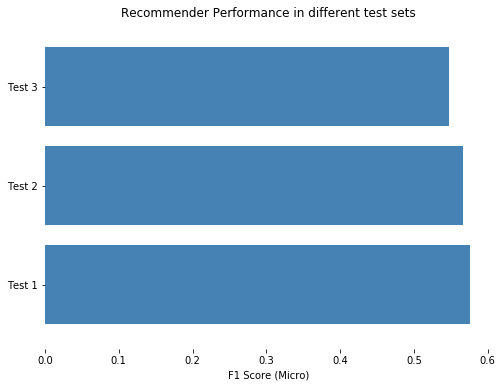

In [133]:
pd.DataFrame(benchmark_data)['Recommender'].sort_values(ascending=False).plot(kind='barh', 
                                                                             figsize=(8,6),
                                                                             width=0.8,
                                                                             color='steelblue')
                                                
plt.xlabel('F1 Score (Micro)')
plt.title('Recommender Performance in different test sets')
plt.box(False)
plt.show()

The recommender scores had no significant changes using different datasets, demonstrating **a good level of generalization**

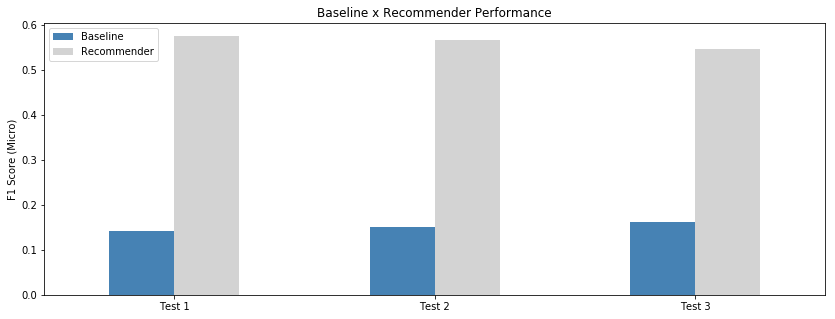

In [134]:
pd.DataFrame(benchmark_data).plot(kind='bar', 
                                  figsize=(14,5), 
                                  colors=['steelblue', 'lightgrey'])
plt.xticks(rotation=0)
plt.ylabel('F1 Score (Micro)')
plt.title('Baseline x Recommender Performance')
plt.legend(loc=2)
plt.show()

The baseline model **does not seem to be a good solution** according to F1-Scores specially compared to recommender scores

## 8 - Conclusion and Improvements

Let's recap the steps took until here so we can interpret the outcomes properly. 

We have collected data of opened emails events from Dito's CRM platform from January to November 2018. Then the data was split into train and test sets, with events until October in the training set and November in test set.

The main goal was to suggest the best time (in the future) that people would open their emails, so with no access to November data in the training phase the recommender should be able to predict an open time from November. 

### The success criteria is:  after learning from past data the model should be able to suggest an hour-range that people would open an email.


### What factors make people open their emails?

Open rate according to Marketing Industry researchers usually hit on average about **18% to 20%** and also by Dito's customers set of campaigns, <u>open rate hardly hit the lower boundary of 18%.</u> So for a certain campaign with 1K eligible people, we usually expect that maximum of 20% (200 people) will open the email. 

But what drives them to open? Or even more important to know, what prevents them to open?

It could be due to many external factors like content of interests, the customer engagement with the brand/company, the current stage of their lives (for example male customers might not open emails about pregnancy until his wife get pregnant) and the hypothesis of this project is **the time you send an email is one of the factors that could prevent them to open it when it's not a good time**

The current process of Dito's customers have no mechanisms to suggest send times, so they are sent on random times or based on overall trends like sending always on Tuesdays at 10 A.M. <u>We know that people have different behaviors and using generic solutions are not the best way to engage customers.</u>

So with the presented F1-Score results showing that we could correctly predict the optimal send time about 55% of the times, **we can say that this solution could actually help to increase campaigns open rate, by reaching at least 55% of eligible people at better times and reducing the cases where time is a preventing factor of email openings**

> ### This can only be tested with a higher assurance using controlled tests checking the open rate of optimal group (people with best time recommended) and controlled group (people without any optimization).


### Improvements

Some improvements might be considered like cluster's hyper-parameter tunning, reducing prediction time to use it with high volume of data and framing this problem differently exploring others techniques.

**Multi Armed Bandit** and **Reinforcement Learning algorithms** might be tested in the future in an attempt to increase and optimize the outcomes.